# Step 1: Imports

In [1]:
from typing import List, Tuple
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

def load_raw_data(filename: str) -> pd.DataFrame:
    mens_filepath = f"/kaggle/input/warmup-round-march-machine-learning-mania-2023/M{filename}.csv"
    weomens_filepath = f"/kaggle/input/warmup-round-march-machine-learning-mania-2023/W{filename}.csv"
    df_mens = pd.read_csv(mens_filepath)
    df_mens["Gender"] = 0
    df_weomens = pd.read_csv(weomens_filepath)
    df_weomens["Gender"] = 1
    return pd.concat([df_mens, df_weomens])

# Step 2: Load the data

In [2]:
RegularSeasonDetailedResults = load_raw_data("RegularSeasonDetailedResults")
RegularSeasonDetailedResults.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender
70673,2023,127,3415,63,3142,54,N,0,20,56,2,10,21,30,11,23,9,14,5,2,22,17,43,4,13,16,21,1,21,5,15,7,2,24,1
70674,2023,127,3424,71,3361,68,H,0,23,55,2,12,23,33,10,23,12,14,7,6,16,28,58,5,10,7,10,7,24,12,13,4,1,26,1
70675,2023,127,3455,65,3378,53,A,0,24,51,6,13,11,13,2,28,14,11,7,2,12,19,60,4,22,11,13,8,22,11,12,2,6,12,1
70676,2023,127,3461,65,3161,56,H,0,25,57,5,17,10,16,13,35,15,14,3,2,13,21,55,9,24,5,8,1,20,12,8,8,4,17,1
70677,2023,127,3477,65,3230,62,A,0,23,50,3,13,16,19,12,20,10,9,6,0,11,22,51,8,22,10,12,8,15,12,9,5,1,13,1


In [3]:
NCAATourneyDetailedResults = load_raw_data("NCAATourneyDetailedResults")
NCAATourneyDetailedResults.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender
755,2022,147,3163,91,3301,87,N,2,37,77,5,21,12,20,12,23,10,7,5,2,16,32,66,7,23,16,19,6,30,20,13,4,7,16,1
756,2022,147,3257,62,3276,50,N,0,25,58,5,15,7,9,6,20,12,11,15,4,17,16,46,3,14,15,20,10,24,9,21,6,2,12,1
757,2022,151,3163,63,3390,58,N,0,21,57,5,14,16,20,12,30,14,19,5,2,16,23,66,4,23,8,13,11,23,10,11,11,3,16,1
758,2022,151,3376,72,3257,59,N,0,27,57,6,17,12,17,8,24,19,14,11,4,11,27,63,1,8,4,7,11,18,5,15,13,2,17,1
759,2022,153,3376,64,3163,49,N,0,22,60,3,16,17,26,18,23,9,14,6,4,11,22,54,4,16,1,4,3,16,14,14,4,5,21,1


In [4]:
NCAATourneySeeds = load_raw_data("NCAATourneySeeds")
NCAATourneySeeds.tail()

,Season,Seed,TeamID,Gender
1535,2022,Z12,3125,1
1536,2022,Z13,3138,1
1537,2022,Z14,3110,1
1538,2022,Z15,3218,1
1539,2022,Z16,3107,1


# Step 3: Prepare the data



In [5]:
def process_detailed_results(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    df = clean_detailed_results(df)
    df = aggregate_detailed_results(df)
    #df = compute_percentages(df)
    return df

def clean_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(["WLoc", "DayNum"], axis=1)

def reshape_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    winner_columns, looser_columns = split_winner_and_looser_columns(df)
    df_winner = df.copy()
    df_winner = df_winner[winner_columns]
    df_winner.columns = clean_column_names(df_winner)
    df_winner["Win"] = 1
    df_looser = df.copy()
    df_looser = df_looser[looser_columns]
    df_looser.columns = clean_column_names(df_looser)
    df_looser["Win"] = 0
    return pd.concat([df_winner, df_looser], ignore_index=True)

def aggregate_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    df = reshape_detailed_results(df)
    df_agg = df.groupby(["Season", "TeamID"]).agg("median")
    return df_agg.reset_index()

def compute_percentages(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    df["FGP"] =  df["FGM"] / df["FGA"]
    df["FGP3"] =  df["FGM3"] / df["FGA3"]
    df["FTP"] =  df["FTM"] / df["FTA"]
    return df

def split_winner_and_looser_columns(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    winner_columns = [name for name in df.columns if not name.startswith("L")]
    looser_columns = [name for name in df.columns if not name.startswith("W")]
    return winner_columns, looser_columns

def clean_column_names(df: pd.DataFrame) -> List[str]:
    column_names = [
        name[1:] if 
        name.startswith("L") or name.startswith("W")
        else name 
        for name in df.columns
    ]
    return column_names

# Test data
test_df = pd.DataFrame([
    {"Season": 1, "WTeamID": "A", "LTeamID": "B", "stat1": 1, "Wstat2": 2, "Lstat2": 3 },
    {"Season": 1, "WTeamID": "A", "LTeamID": "B", "stat1": 4, "Wstat2": 5, "Lstat2": 6 },
])
expected_column_names = [
    "Season", "TeamID", "TeamID", "stat1", "stat2", "stat2"
]
expected_column_split = (
    ["Season", "WTeamID", "stat1", "Wstat2"], 
    ["Season", "LTeamID", "stat1", "Lstat2"]
)
expected_reshaped_df = pd.DataFrame([
    { "Season": 1, "TeamID": "A", "stat1": 1, "stat2": 2, "Win": 1 },
    { "Season": 1, "TeamID": "A", "stat1": 4, "stat2": 5, "Win": 1 },
    { "Season": 1, "TeamID": "B", "stat1": 1, "stat2": 3, "Win": 0 },
    { "Season": 1, "TeamID": "B", "stat1": 4, "stat2": 6, "Win": 0 },
    
])
expected_aggregated_df = pd.DataFrame([
    {"Season": 1, "TeamID": "A", "stat1": 2.5, "stat2": 3.5, "Win": 1.0 },
    {"Season": 1, "TeamID": "B","stat1": 2.5, "stat2": 4.5, "Win": 0.0 },
])
test_df_copy = test_df.copy()

# Tests
assert clean_column_names(test_df) == expected_column_names, "Function clean_column_names failed."
assert split_winner_and_looser_columns(test_df) == expected_column_split, "Function split_winner_and_looser_columns failed."
assert expected_reshaped_df.equals(reshape_detailed_results(test_df)), "Function reshape_detailed_results failed."
assert expected_aggregated_df.equals(aggregate_detailed_results(test_df)), "Function aggregate_detailed_results failed."

In [6]:
ProcessedRegularSeasonDetailedResults = process_detailed_results(
    RegularSeasonDetailedResults
)
ProcessedRegularSeasonDetailedResults.tail()

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Gender,Win
12130,2023,3473,56.0,0.0,21.0,51.0,7.0,21.0,8.0,13.0,6.0,19.0,12.0,19.0,6.0,2.0,16.0,1.0,0.0
12131,2023,3474,57.5,0.0,20.0,58.5,4.0,15.0,12.5,17.5,8.0,20.0,7.0,14.0,7.0,2.0,21.5,1.0,0.0
12132,2023,3475,59.5,0.0,21.0,55.5,4.0,16.0,15.0,19.0,9.0,24.0,13.0,20.5,7.0,2.0,19.0,1.0,0.0
12133,2023,3476,61.0,0.0,22.0,56.5,6.0,21.0,9.5,12.0,9.0,21.0,13.5,14.5,3.0,3.0,14.0,1.0,0.0
12134,2023,3477,65.0,0.0,22.0,58.0,4.0,14.0,14.0,21.0,11.0,23.0,11.0,16.0,7.0,3.0,15.0,1.0,0.0


In [7]:
ProcessedNCAATourneyDetailedResults = process_detailed_results(
    NCAATourneyDetailedResults
)

ProcessedNCAATourneyDetailedResults.tail()

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Gender,Win
2034,2022,3426,71.0,0.0,27.0,62.0,7.0,16.0,10.0,16.0,7.0,26.0,11.0,9.0,6.0,5.0,20.0,1.0,0.0
2035,2022,3428,74.0,0.0,27.5,53.5,10.5,25.5,8.5,12.0,6.0,25.5,16.5,17.5,3.0,1.5,14.5,1.0,0.5
2036,2022,3437,55.0,0.0,20.5,58.5,6.0,23.5,8.0,12.0,7.5,19.5,11.0,10.0,8.5,5.0,18.0,1.0,0.5
2037,2022,3439,81.0,0.0,30.0,60.0,6.0,17.0,15.0,20.0,7.0,28.0,13.0,10.0,1.0,1.0,13.0,1.0,0.0
2038,2022,3450,40.0,0.0,14.0,56.0,3.0,22.0,9.0,14.0,8.0,31.0,5.0,17.0,2.0,2.0,23.0,1.0,0.0


In [8]:
def process_seeds(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    mask = df["Season"] > 2002
    df = df[mask]
    df["Seed"] = df["Seed"].str.replace(r"\D+","", regex=True)
    df["Seed"] = df["Seed"].astype(int)
    return df

In [9]:
ProcessedNCAATourneySeeds = process_seeds(NCAATourneySeeds)
ProcessedNCAATourneySeeds.tail()

,Season,Seed,TeamID,Gender
1535,2022,12,3125,1
1536,2022,13,3138,1
1537,2022,14,3110,1
1538,2022,15,3218,1
1539,2022,16,3107,1


## Merge features

In [10]:
ProcessedNCAATourneyDetailedResults["Season"] += 1
features = pd.merge(
    ProcessedRegularSeasonDetailedResults,
    ProcessedNCAATourneyDetailedResults,
    how="inner",
    on=["Season", "TeamID"],
    suffixes=("Reg", "Tou")
)

features = features.merge(
    ProcessedNCAATourneySeeds,
    how="inner",
    on=["Season", "TeamID"]
)

features.tail()

,Season,TeamID,ScoreReg,NumOTReg,FGMReg,FGAReg,FGM3Reg,FGA3Reg,FTMReg,FTAReg,ORReg,DRReg,AstReg,TOReg,StlReg,BlkReg,PFReg,GenderReg,WinReg,ScoreTou,NumOTTou,FGMTou,FGATou,FGM3Tou,FGA3Tou,FTMTou,FTATou,ORTou,DRTou,AstTou,TOTou,StlTou,BlkTou,PFTou,GenderTou,WinTou,Seed,Gender
977,2022,3397,68.0,0.0,24.0,64.0,4.0,15.0,12.0,20.0,13.0,29.0,13.0,16.0,6.0,6.0,15.0,1.0,1.0,71.0,0.0,27.0,62.5,2.0,13.0,15.0,19.0,17.0,29.0,10.0,18.0,7.5,7.0,15.5,1.0,0.5,4,1
978,2022,3400,70.0,0.0,25.5,61.0,4.0,13.5,12.5,19.0,11.5,21.0,13.0,13.0,9.0,3.0,18.0,1.0,1.0,67.5,0.0,24.5,59.5,6.0,16.0,12.5,17.0,9.5,22.0,9.5,10.0,5.5,2.0,14.0,1.0,1.0,2,1
979,2022,3416,61.0,0.0,23.0,56.0,3.0,10.5,11.0,16.0,11.0,21.5,13.5,14.0,10.5,3.5,13.0,1.0,1.0,51.0,0.0,21.0,57.0,3.0,13.0,6.0,12.0,13.0,22.0,10.0,19.0,5.0,2.0,22.0,1.0,0.0,7,1
980,2022,3439,70.5,0.0,24.0,55.0,8.5,23.0,10.0,15.5,8.0,24.5,14.5,12.0,5.0,4.0,15.0,1.0,1.0,59.0,0.0,21.0,56.0,6.5,20.0,10.5,12.5,6.5,19.5,14.0,14.0,5.5,1.5,18.0,1.0,0.5,5,1
981,2022,3450,62.0,0.0,22.0,58.0,7.0,21.0,9.0,12.0,9.0,22.0,12.0,13.0,8.0,4.0,16.0,1.0,1.0,53.0,0.0,17.0,55.0,8.0,25.0,11.0,12.0,8.0,24.0,11.0,11.0,6.0,4.0,15.0,1.0,0.0,8,1


## Build Dataset

In [11]:
def get_outcomes(df):
    input_rows = df.to_records()
    output_rows = [parse_row(input_row) for input_row in input_rows]
    out_df = pd.DataFrame(output_rows)
    out_df = out_df[out_df["Season"] < 2017]
    return out_df

def parse_row(row):
    season = row['Season']
    winning_team_id = row['WTeamID']
    losing_team_id = row['LTeamID']
    if winning_team_id < losing_team_id:
        small_id = winning_team_id
        big_id = losing_team_id
        outcome = 1
    elif losing_team_id < winning_team_id:
        small_id = losing_team_id
        big_id = winning_team_id
        outcome = 0
    record = {
        "ID": f"{season}_{small_id}_{big_id}",
        'Season': season,
        'LowID': small_id,
        'HighID': big_id,
        'Win': outcome
    }
    return record

In [12]:
outcomes = get_outcomes(NCAATourneyDetailedResults)
print(outcomes.shape)
outcomes.tail()

(1355, 5)


,ID,Season,LowID,HighID,Win
1684,2016_3163_3400,2016,3163,3400,1
1685,2016_3124_3333,2016,3124,3333,0
1686,2016_3163_3333,2016,3163,3333,1
1687,2016_3393_3449,2016,3393,3449,1
1688,2016_3163_3393,2016,3163,3393,1


In [13]:
def merge_outcomes_with_features(outcomes: pd.DataFrame, features: pd.DataFrame) -> pd.DataFrame:
    data = pd.merge(
        outcomes, 
        features, 
        how="left", 
        left_on=["Season", "HighID"], 
        right_on=["Season", "TeamID"]
    )
    data = pd.merge(
        data, 
        features, 
        how="left", 
        left_on=["Season", "LowID"], 
        right_on=["Season", "TeamID"],
        suffixes=("High", "Low")
    )
    data.drop(
        ["Season", "HighID", "LowID","TeamIDHigh","TeamIDLow"], 
        axis=1, 
        inplace=True
    )
    data.set_index("ID", inplace=True)
    return data

In [14]:
data = merge_outcomes_with_features(outcomes, features)
print(data.shape)
data.tail()

(1355, 73)


,Win,ScoreRegHigh,NumOTRegHigh,FGMRegHigh,FGARegHigh,FGM3RegHigh,FGA3RegHigh,FTMRegHigh,FTARegHigh,ORRegHigh,DRRegHigh,AstRegHigh,TORegHigh,StlRegHigh,BlkRegHigh,PFRegHigh,GenderRegHigh,WinRegHigh,ScoreTouHigh,NumOTTouHigh,FGMTouHigh,FGATouHigh,FGM3TouHigh,FGA3TouHigh,FTMTouHigh,FTATouHigh,ORTouHigh,DRTouHigh,AstTouHigh,TOTouHigh,StlTouHigh,BlkTouHigh,PFTouHigh,GenderTouHigh,WinTouHigh,SeedHigh,GenderHigh,ScoreRegLow,NumOTRegLow,FGMRegLow,FGARegLow,FGM3RegLow,FGA3RegLow,FTMRegLow,FTARegLow,ORRegLow,DRRegLow,AstRegLow,TORegLow,StlRegLow,BlkRegLow,PFRegLow,GenderRegLow,WinRegLow,ScoreTouLow,NumOTTouLow,FGMTouLow,FGATouLow,FGM3TouLow,FGA3TouLow,FTMTouLow,FTATouLow,ORTouLow,DRTouLow,AstTouLow,TOTouLow,StlTouLow,BlkTouLow,PFTouLow,GenderTouLow,WinTouLow,SeedLow,GenderLow
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016_3163_3400,1,70.0,0.0,26.0,60.0,4.0,13.0,13.0,19.5,14.5,28.0,13.5,16.5,7.0,5.0,18.5,1.0,1.0,66.0,0.0,28.0,59.0,1.0,13.0,9.0,13.0,16.0,26.0,15.0,18.0,2.0,3.0,15.0,1.0,1.0,2.0,1.0,87.0,0.0,34.0,65.5,8.0,21.0,11.0,14.0,13.0,28.0,22.0,11.0,12.0,6.5,11.5,1.0,1.0,90.0,0.0,33.0,63.5,8.5,22.5,14.0,16.5,12.5,26.5,19.5,11.0,8.0,6.5,10.0,1.0,1.0,1.0,1.0
2016_3124_3333,0,63.5,0.0,24.5,57.0,7.0,18.0,10.0,15.5,12.5,32.5,15.0,15.5,5.0,5.5,14.5,1.0,1.0,69.0,0.0,22.5,52.5,8.0,23.0,16.0,23.0,9.5,24.5,14.5,15.0,8.5,6.5,17.0,1.0,0.5,2.0,1.0,78.0,0.0,30.0,60.5,4.0,9.0,14.5,21.5,12.5,30.5,20.0,15.5,8.0,6.0,14.5,1.0,1.0,75.0,0.0,29.5,63.5,3.0,9.5,15.5,19.0,14.0,31.5,22.0,9.5,6.5,6.5,13.5,1.0,1.0,1.0,1.0
2016_3163_3333,1,63.5,0.0,24.5,57.0,7.0,18.0,10.0,15.5,12.5,32.5,15.0,15.5,5.0,5.5,14.5,1.0,1.0,69.0,0.0,22.5,52.5,8.0,23.0,16.0,23.0,9.5,24.5,14.5,15.0,8.5,6.5,17.0,1.0,0.5,2.0,1.0,87.0,0.0,34.0,65.5,8.0,21.0,11.0,14.0,13.0,28.0,22.0,11.0,12.0,6.5,11.5,1.0,1.0,90.0,0.0,33.0,63.5,8.5,22.5,14.0,16.5,12.5,26.5,19.5,11.0,8.0,6.5,10.0,1.0,1.0,1.0,1.0
2016_3393_3449,1,69.0,0.0,26.0,58.5,7.0,21.0,13.0,16.5,9.0,28.0,11.5,13.0,6.5,3.0,13.5,1.0,1.0,80.0,0.0,28.0,69.0,10.0,29.0,14.0,19.0,10.0,30.0,17.0,6.0,2.0,1.0,23.0,1.0,0.0,7.0,1.0,71.0,0.0,24.0,66.0,8.0,30.0,12.0,17.0,16.5,23.0,12.5,13.5,13.0,4.5,16.5,1.0,1.0,70.0,0.0,24.5,66.0,7.0,23.5,14.0,22.0,15.0,23.5,11.0,10.5,6.5,4.0,21.0,1.0,0.5,4.0,1.0
2016_3163_3393,1,71.0,0.0,24.0,66.0,8.0,30.0,12.0,17.0,16.5,23.0,12.5,13.5,13.0,4.5,16.5,1.0,1.0,70.0,0.0,24.5,66.0,7.0,23.5,14.0,22.0,15.0,23.5,11.0,10.5,6.5,4.0,21.0,1.0,0.5,4.0,1.0,87.0,0.0,34.0,65.5,8.0,21.0,11.0,14.0,13.0,28.0,22.0,11.0,12.0,6.5,11.5,1.0,1.0,90.0,0.0,33.0,63.5,8.5,22.5,14.0,16.5,12.5,26.5,19.5,11.0,8.0,6.5,10.0,1.0,1.0,1.0,1.0


## Train Test Split 

In [15]:
# For splitting data
from sklearn.model_selection import train_test_split

# Create train, validate, and test sets.
X = data.copy().drop("Win", axis=1)
y = data["Win"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

X_train.shape

(1016, 72)

# Step 4: Train a model


### Setup Hyperparameter Tuning
See https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Training Score: 0.7057086614173228
Validation Score: 0.672566371681416
Brier Score Validation: 0.3274336283185841
ROC AUC Validation: 0.6716269841269841
- boosting_type: gbdt
- class_weight: None
- colsample_bytree: 1.0
- importance_type: split
- learning_rate: 0.1
- max_depth: -1
- min_child_samples: 20
- min_child_weight: 0.001
- min_split_gain: 0.0
- n_estimators: 100
- n_jobs: -1
- num_leaves: 31
- objective: None
- random_state: None
- reg_alpha: 0.0
- reg_lambda: 0.0
- silent: warn
- subsample: 1.0
- subsample_for_bin: 200000
- subsample_freq: 0
- min_data_in_leaf: 300


<AxesSubplot:>

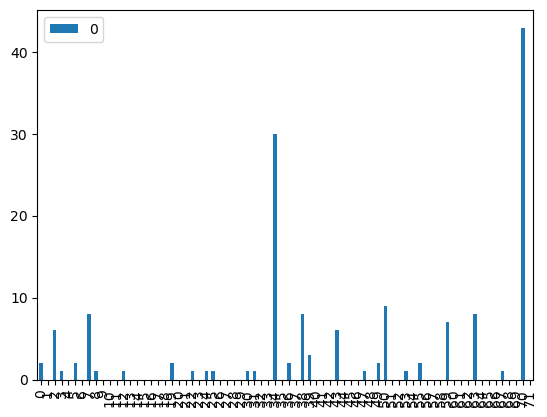

In [16]:
from sklearn.metrics import brier_score_loss, roc_auc_score, confusion_matrix
import lightgbm

model = lightgbm.LGBMClassifier(min_data_in_leaf=300)
model.fit(X_train, y_train)

preds_train = model.predict(X_train)
preds_valid = model.predict(X_valid)

print("Training Score:", model.score(X_train, y_train))
print("Validation Score:", model.score(X_valid, y_valid))
print("Brier Score Validation:", brier_score_loss(y_valid, preds_valid))
print("ROC AUC Validation:", roc_auc_score(y_valid, preds_valid))
print(*(f"- {key}: {value}" for key, value in model.get_params(deep=True).items()), sep="\n")

pd.DataFrame(model.feature_importances_).plot.bar()


# Step 5: Submit to the competition

We"ll begin by using the trained model to generate predictions, which we"ll save to a CSV file.

In [17]:
SampleSubmissionWarmup = pd.read_csv("/kaggle/input/warmup-round-march-machine-learning-mania-2023/SampleSubmissionWarmup.csv")

print(SampleSubmissionWarmup.shape)
SampleSubmissionWarmup.tail()

(614319, 2)


,ID,Pred
614314,2022_3469_3471,0.5
614315,2022_3469_3472,0.5
614316,2022_3470_3471,0.5
614317,2022_3470_3472,0.5
614318,2022_3471_3472,0.5


In [18]:
def get_submission_outcomes(sample_submission: pd.DataFrame) -> pd.DataFrame:
    df = sample_submission.copy()
    df.drop("Pred", axis=1, inplace=True)
    df[["Season", "LowID", "HighID"]] = df["ID"].str.split("_", expand=True)
    df[["Season", "LowID", "HighID"]] = df[["Season", "LowID", "HighID"]].astype(int)
    return df

In [19]:
submission_outcomes = get_submission_outcomes(SampleSubmissionWarmup)
print(submission_outcomes.shape)
submission_outcomes.tail()

(614319, 4)


,ID,Season,LowID,HighID
614314,2022_3469_3471,2022,3469,3471
614315,2022_3469_3472,2022,3469,3472
614316,2022_3470_3471,2022,3470,3471
614317,2022_3470_3472,2022,3470,3472
614318,2022_3471_3472,2022,3471,3472


In [20]:
X_submission = merge_outcomes_with_features(submission_outcomes, features)
print(X_submission.shape)
X_submission.describe()

(614319, 72)


,ScoreRegHigh,NumOTRegHigh,FGMRegHigh,FGARegHigh,FGM3RegHigh,FGA3RegHigh,FTMRegHigh,FTARegHigh,ORRegHigh,DRRegHigh,AstRegHigh,TORegHigh,StlRegHigh,BlkRegHigh,PFRegHigh,GenderRegHigh,WinRegHigh,ScoreTouHigh,NumOTTouHigh,FGMTouHigh,FGATouHigh,FGM3TouHigh,FGA3TouHigh,FTMTouHigh,FTATouHigh,ORTouHigh,DRTouHigh,AstTouHigh,TOTouHigh,StlTouHigh,BlkTouHigh,PFTouHigh,GenderTouHigh,WinTouHigh,SeedHigh,GenderHigh,ScoreRegLow,NumOTRegLow,FGMRegLow,FGARegLow,FGM3RegLow,FGA3RegLow,FTMRegLow,FTARegLow,ORRegLow,DRRegLow,AstRegLow,TORegLow,StlRegLow,BlkRegLow,PFRegLow,GenderRegLow,WinRegLow,ScoreTouLow,NumOTTouLow,FGMTouLow,FGATouLow,FGM3TouLow,FGA3TouLow,FTMTouLow,FTATouLow,ORTouLow,DRTouLow,AstTouLow,TOTouLow,StlTouLow,BlkTouLow,PFTouLow,GenderTouLow,WinTouLow,SeedLow,GenderLow
count,49144.000000,49144.0,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49144.000000,49499.000000,49499.0,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.00000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000,49499.000000
mean,74.566336,0.0,26.820497,59.765180,6.940288,20.198559,12.922442,18.051563,11.231890,25.843440,14.775568,12.571433,6.906825,3.726315,16.321341,0.512921,0.989470,68.773340,0.047768,25.129466,59.582197,6.422117,19.775547,11.912431,16.661953,10.963210,24.090479,12.940359,12.229865,5.977566,3.719671,17.222316,0.512921,0.533473,6.509849,0.512921,75.046708,0.0,27.217287,59.972828,6.992687,20.388119,12.776723,17.892220,11.197004,25.906069,15.320501,12.743106,7.000717,3.762207,16.218156,0.558840,0.996293,69.530162,0.024112,25.470959,59.627447,6.447858,19.731671,11.986343,16.758712,10.834795,23.774793,13.383119,12.44410,6.237783,3.537587,17.254217,0.558840,0.519899,6.861351,0.558840
std,6.192280,0.0,2.447293,3.844439,1.783260,4.343014,2.220221,2.857248,2.401486,2.375018,2.071337,2.001004,1.666071,1.115731,1.913355,0.499838,0.090591,11.306789,0.229821,4.364509,5.889314,2.522260,5.804685,4.299554,5.356204,3.696972,4.918266,3.683506,3.615624,2.377517,1.975872,3.650031,0.499838,0.427875,4.283826,0.499838,6.376330,0.0,2.602603,3.660747,1.904201,4.811555,2.207888,2.953934,2.195366,2.615746,2.377765,1.861887,1.697928,1.212708,1.956835,0.496531,0.048425,10.961831,0.163703,4.318365,5.879381,2.510879,5.747769,4.430901,5.502889,3.745145,4.496815,3.931441,3.55931,2.531988,1.923293,3.508644,0.496531,0.420335,4.446288,0.496531
min,61.000000,0.0,21.000000,50.000000,2.500000,8.500000,7.000000,11.000000,6.000000,18.000000,10.000000,8.000000,3.000000,1.000000,9.000000,0.000000,0.000000,31.000000,0.000000,12.000000,40.000000,0.000000,7.000000,2.000000,3.000000,3.000000,9.000000,3.000000,4.000000,1.000000,0.000000,9.000000,0.000000,0.000000,1.000000,0.000000,61.000000,0.0,21.000000,50.000000,2.500000,8.500000,7.000000,11.000000,6.000000,18.000000,10.000000,8.000000,3.000000,1.000000,9.000000,0.000000,0.000000,31.000000,0.000000,12.000000,40.000000,0.000000,7.000000,2.000000,3.000000,3.000000,9.000000,3.000000,4.00000,1.000000,0.000000,9.000000,0.000000,0.000000,1.000000,0.000000
25%,71.000000,0.0,25.000000,57.000000,6.000000,18.000000,11.000000,16.000000,9.000000,24.000000,13.500000,11.000000,6.000000,3.000000,15.000000,0.000000,1.000000,62.000000,0.000000,22.000000,55.500000,4.500000,16.000000,9.000000,13.000000,8.500000,21.000000,10.000000,10.000000,4.000000,2.000000,15.000000,0.

In [21]:
# Use the model to generate predictions

predictions = model.predict(X_submission)

# Save the predictions to a CSV file
output = pd.DataFrame({"ID": X_submission.index,
                       "Pred": predictions})
output.to_csv("submission.csv", index=False)
print(output.shape)
output.describe()

(614319, 2)


,Pred
count,614319.000000
mean,0.903959
std,0.294648
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000
